In [40]:
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import xarray as xr
import glob
import om4labs.om4common as om4

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = '/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/'
out_path_data = '/work/Katherine.Turner/smaller_projects/hifreq-variability/data/'

In [2]:
df = pd.read_csv('/work/Katherine.Turner/tempest-extremes/ESM4/node_files/SH_SN.csv', delimiter='\t')

In [3]:
df.loc[df['Month'].isin([1,2]), 'SeasonYear'] = df['Year'] - 1
df.loc[df['Month'].isin([3,4,5,6,7,8,9,10,11,12]), 'SeasonYear'] = df['Year']
df

,Event,Year,Month,Day,Time,Lon,Lat,SLP,Windspeed,SeasonYear
0,1,1,1,1,6,61.875,-52.5,97253.26,18.92103,0.0
1,1,1,1,1,12,63.125,-55.5,97056.53,20.13886,0.0
2,1,1,1,1,18,63.125,-58.5,97113.02,19.76665,0.0
3,1,1,1,2,0,61.875,-59.5,96797.90,16.56477,0.0
4,1,1,1,2,6,59.375,-60.5,96603.87,17.29902,0.0
...,...,...,...,...,...,...,...,...,...,...
901786,48732,100,12,31,0,208.125,-59.5,97451.93,14.46151,100.0
901787,48732,100,12,31,6,213.125,-60.5,97489.36,14.13835,100.0
901788,48732,100,12,31,12,218.125,-61.5,97586.23,14.61312,100.0
901789,48732,100,12,31,18,224.375,-62.5,97798.56,13.76056,100.0


In [4]:
df_winter = df[df['Month'].isin([6,7,8])]
df_summer = df[df['Month'].isin([1,2,12])]

In [5]:
year_counts_winter = df_winter['SeasonYear'].value_counts().sort_index()
year_counts_summer = df_summer['SeasonYear'].value_counts().sort_index()

year_counts_winter.index = year_counts_winter.index.astype(int)
year_counts_summer.index = year_counts_summer.index.astype(int)

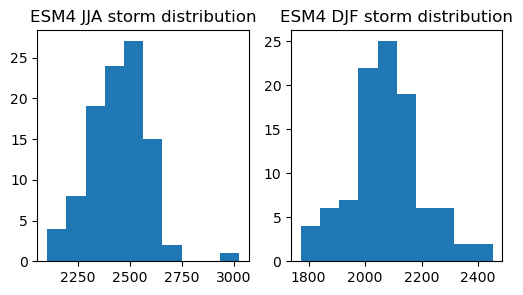

In [49]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(6,3))

axs[0].hist(year_counts_winter, bins=10)
axs[0].set_title('ESM4 JJA storm distribution')
axs[1].hist(year_counts_summer[1:-1], bins=10)
axs[1].set_title('ESM4 DJF storm distribution')

plt.savefig(f'{out_path_fig}ESM4_storm_dist.png', format='png', dpi=100)

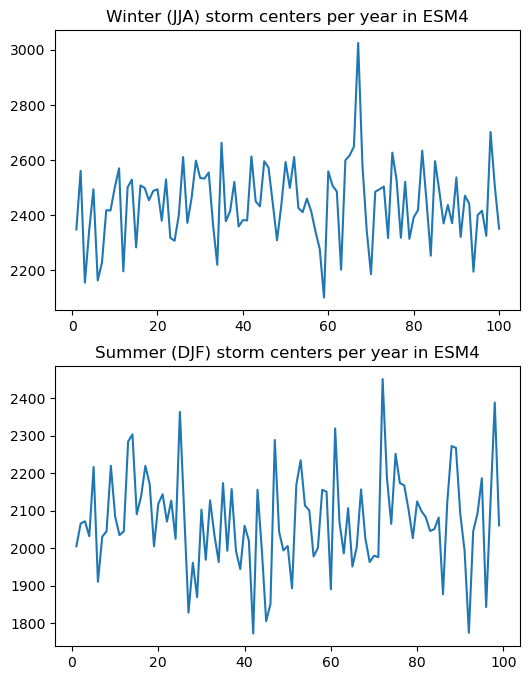

In [11]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6,8))

year_counts_winter.plot(ax=axs[0])
axs[0].set_title('Winter (JJA) storm centers per year in ESM4')

year_counts_summer[1:-1].plot(ax=axs[1])
axs[1].set_title('Summer (DJF) storm centers per year in ESM4')

plt.savefig('/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/ESM4_storm_activity_seasonal.png', format='png', dpi=100)

In [12]:
np.corrcoef(year_counts_winter[1:], year_counts_summer[1:-1])

array([[ 1.        , -0.05061175],
       [-0.05061175,  1.        ]])

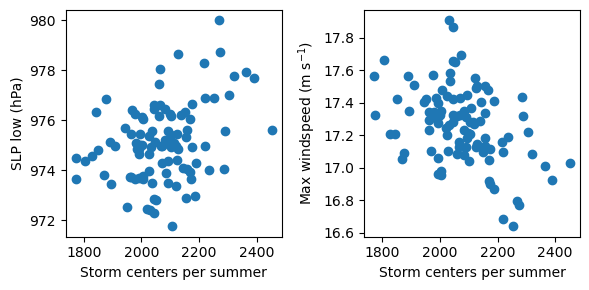

In [13]:
event_counts = np.zeros(len(year_counts_summer[1:-1]))
mean_slp = np.zeros(len(year_counts_summer[1:-1]))
mean_windmax = np.zeros(len(year_counts_summer[1:-1]))
for i, year in enumerate(year_counts_summer[1:-1].index):
    event_counts[i] = len(df_summer[df_summer['SeasonYear'] == year]['Event'].value_counts())
    mean_slp[i] = df_summer[df_summer['SeasonYear'] == year]['SLP'].mean()
    mean_windmax[i] = df_summer[df_summer['SeasonYear'] == year]['Windspeed'].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].scatter(year_counts_summer[1:-1], 1e-2*mean_slp)
axs[1].scatter(year_counts_summer[1:-1], mean_windmax)

axs[0].set_ylabel('SLP low (hPa)')
axs[0].set_xlabel('Storm centers per summer')

axs[1].set_ylabel('Max windspeed (m s$^{-1}$)')
axs[1].set_xlabel('Storm centers per summer')
#np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

In [14]:
print(np.corrcoef(year_counts_summer[1:-1], mean_slp)[0,1])
print(np.corrcoef(year_counts_summer[1:-1], mean_windmax)[0,1])

0.34728194250923217
-0.40005252643591527


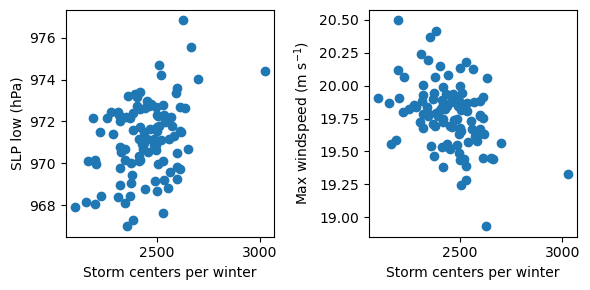

In [15]:
event_counts = np.zeros(len(year_counts_winter))
mean_slp = np.zeros(len(year_counts_winter))
mean_windmax = np.zeros(len(year_counts_winter))
for i, year in enumerate(year_counts_winter.index):
    event_counts[i] = len(df_winter[df_winter['Year'] == year]['Event'].value_counts())
    mean_slp[i] = df_winter[df_winter['Year'] == year]['SLP'].mean()
    mean_windmax[i] = df_winter[df_winter['Year'] == year]['Windspeed'].mean()

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].scatter(year_counts_winter, 1e-2*mean_slp)
axs[1].scatter(year_counts_winter, mean_windmax)

axs[0].set_ylabel('SLP low (hPa)')
axs[0].set_xlabel('Storm centers per winter')

axs[1].set_ylabel('Max windspeed (m s$^{-1}$)')
axs[1].set_xlabel('Storm centers per winter')
#np.corrcoef(year_counts, mean_windmax)
plt.tight_layout()

In [11]:
low_years_summ = year_counts_summer[1:-1].sort_values()[:7].sort_index().index
high_years_summ = year_counts_summer[1:-1].sort_values()[-7:].sort_index().index

high_years_summ, low_years_summ

(Int64Index([13, 14, 25, 47, 61, 72, 98], dtype='int64'),
 Int64Index([27, 29, 42, 45, 46, 92, 96], dtype='int64'))

In [12]:
low_years_wint = year_counts_winter.sort_values()[:7].sort_index().index
high_years_wint = year_counts_winter.sort_values()[-7:].sort_index().index

high_years_wint, low_years_wint

(Int64Index([35, 65, 66, 67, 75, 82, 98], dtype='int64'),
 Int64Index([3, 6, 12, 59, 63, 70, 94], dtype='int64'))

In [35]:
year_counts_summer[1:-1].sort_values()[:7].sum(), year_counts_summer[1:-1].sort_values()[-7:].sum()

(27782, 32057)

In [8]:
ds_mask = xr.open_mfdataset('/work/Katherine.Turner/tempest-extremes/ESM4/dic_stf_gas/masked*.nc', use_cftime=True)
da = ds_mask.resample(time='QS-DEC').sum()

In [24]:
winter_months = [6, 7, 8]
summer_months_p1 = [12]
summer_months_p2 = [1,2]

idx_hi_summ = (ds_mask.time.dt.year.isin(high_years_summ) & ds_mask.time.dt.month.isin(summer_months_p1)) | (ds_mask.time.dt.year.isin(high_years_summ+1) & ds_mask.time.dt.month.isin(summer_months_p2)) 
idx_low_summ = (ds_mask.time.dt.year.isin(low_years_summ) & ds_mask.time.dt.month.isin(summer_months_p1)) | (ds_mask.time.dt.year.isin(low_years_summ+1) & ds_mask.time.dt.month.isin(summer_months_p2))

idx_hi_wint = (ds_mask.time.dt.year.isin(high_years_wint) & ds_mask.time.dt.month.isin(winter_months)) 
idx_low_wint = (ds_mask.time.dt.year.isin(low_years_wint) & ds_mask.time.dt.month.isin(winter_months)) 

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


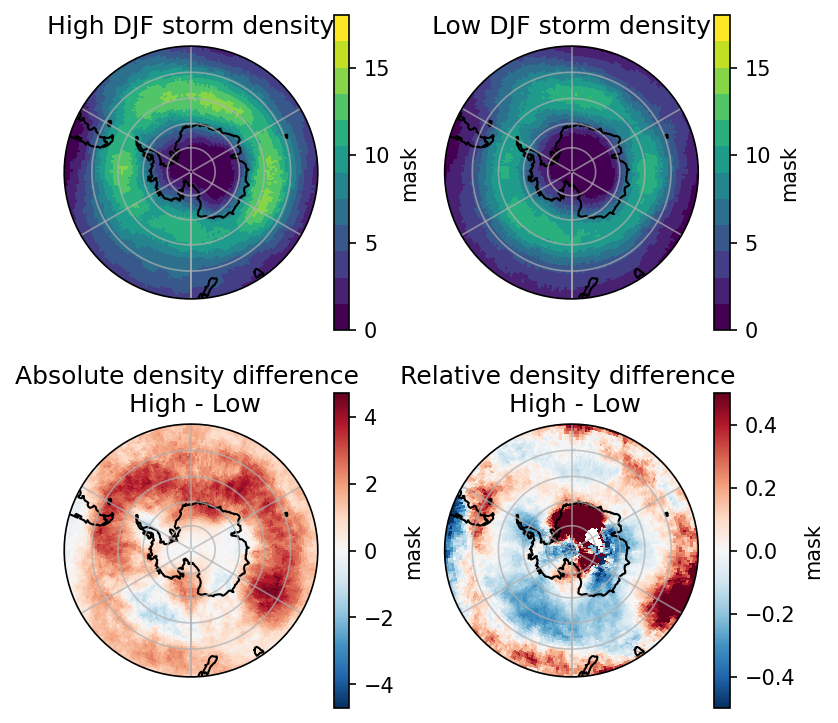

In [50]:
## Summer month storm activity

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), dpi=150,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(3*7) * ds_mask.mask[idx_hi_summ,:,:].sum(dim='time')).plot(ax=axs[0],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

axs[0].set_title('High DJF storm density')

(1/(3*7) * ds_mask.mask[idx_low_summ,:,:].sum(dim='time')).plot(ax=axs[1],
                                                                x='lon', y='lat',
                                                                transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

axs[1].set_title('Low DJF storm density')

(1/(3*7) * (ds_mask.mask[idx_hi_summ,:,:].sum(dim='time') - 
 ds_mask.mask[idx_low_summ,:,:].sum(dim='time'))).plot(ax=axs[2], 
                                                      x='lon', y='lat',
                                                      transform=ccrs.PlateCarree())

axs[2].set_title('Absolute density difference \n High - Low')

((1/2343 * ds_mask.mask[idx_hi_summ,:,:].sum(dim='time') - 
 1/1820 * ds_mask.mask[idx_low_summ,:,:].sum(dim='time')) / 
 (1/1820 * ds_mask.mask[idx_low_summ,:,:].sum(dim='time'))).plot(ax=axs[3],
                                                                  x='lon', y='lat', extend='neither',
                                                                  vmin=-.5, vmax=.5, cmap='RdBu_r',
                                                                  transform=ccrs.PlateCarree())
axs[3].set_title('Relative density difference \n High - Low')

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.savefig(f"{out_path_fig}storm_activity_djf_ESM4.png", format='png', dpi=100)

/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/Katherine.Turner/miniconda3/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


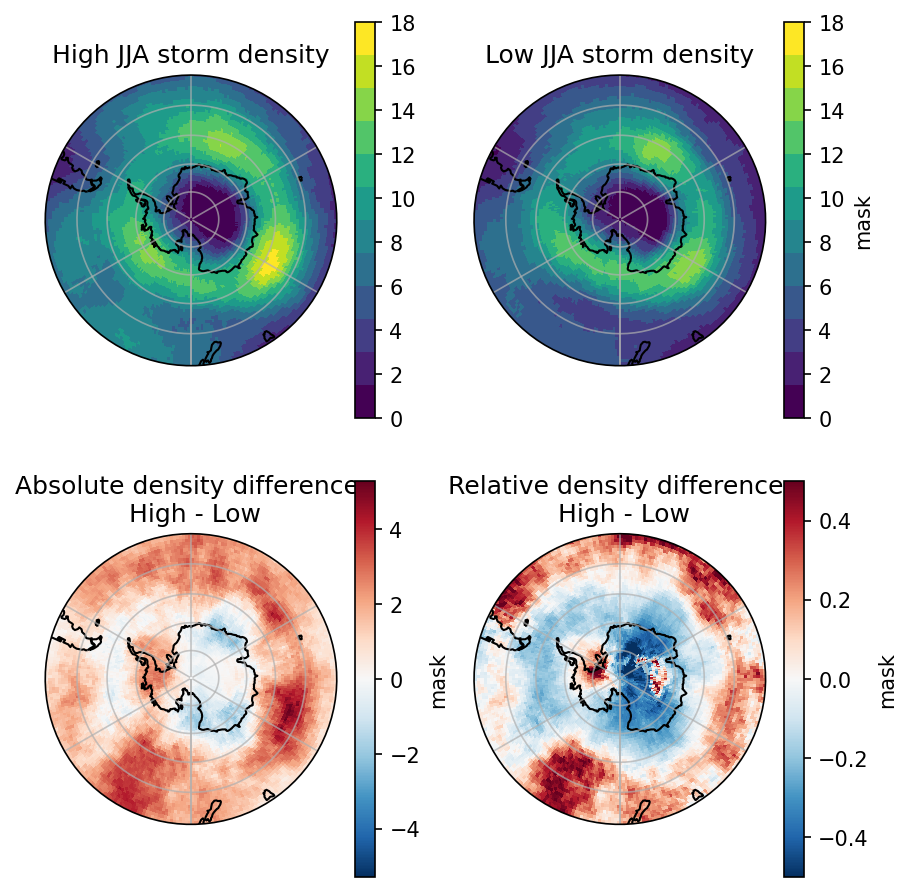

In [51]:
## Winter month storm activity

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), dpi=150,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(3*7) * ds_mask.mask[idx_hi_wint,:,:].sum(dim='time')).plot(ax=axs[0],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                               cbar_kwargs={'label':''})

axs[0].set_title('High JJA storm density')

(1/(3*7) * ds_mask.mask[idx_low_wint,:,:].sum(dim='time')).plot(ax=axs[1],
                                                                x='lon', y='lat',
                                                                transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12))

axs[1].set_title('Low JJA storm density')

(1/(3*7) * (ds_mask.mask[idx_hi_wint,:,:].sum(dim='time') - 
 ds_mask.mask[idx_low_wint,:,:].sum(dim='time'))).plot(ax=axs[2], 
                                                      x='lon', y='lat',
                                                      transform=ccrs.PlateCarree())

axs[2].set_title('Absolute density difference \n High - Low')

((1/2702 * ds_mask.mask[idx_hi_wint,:,:].sum(dim='time') - 
 1/2171 * ds_mask.mask[idx_low_wint,:,:].sum(dim='time')) / 
 (1/2171 * ds_mask.mask[idx_low_wint,:,:].sum(dim='time'))).plot(ax=axs[3],
                                                                  x='lon', y='lat', extend='neither',
                                                                  vmin=-.5, vmax=.5, cmap='RdBu_r',
                                                                  transform=ccrs.PlateCarree())
axs[3].set_title('Relative density difference \n High - Low')

for i in range(4):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.tight_layout()

plt.savefig(f"{out_path_fig}storm_activity_jja_ESM4.png", format='png', dpi=100)

In [28]:
# now just looking at these crazy 3 consecutive years for winter

In [29]:
idx_hi_wint2 = (ds_mask.time.dt.year.isin([56, 66, 67]) & ds_mask.time.dt.month.isin(winter_months)) 
idx_wint = ds_mask.time.dt.month.isin(winter_months) 

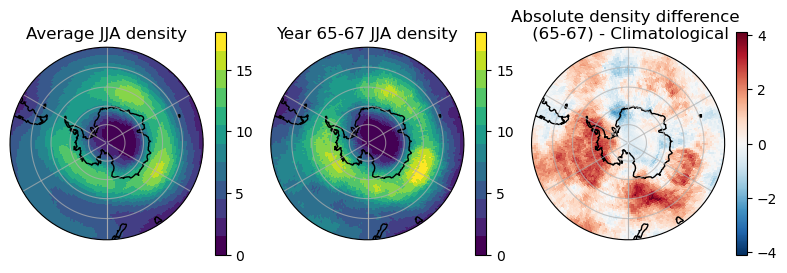

In [52]:
## Winter month storm activity for 65-67

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8,4), dpi=100,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs=axs.flatten()


(1/(3*100) * ds_mask.mask[idx_wint,:,:].sum(dim='time')).plot(ax=axs[0],
                                                               x='lon', y='lat',
                                                               transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                               cbar_kwargs={'label':'',
                                                                            'fraction':0.1,
                                                                            'aspect':20,
                                                                            'shrink':0.60
                                                                           }
                                                             )

axs[0].set_title('Average JJA density')

(1/(3*3) * ds_mask.mask[idx_hi_wint2,:,:].sum(dim='time')).plot(ax=axs[1],
                                                                x='lon', y='lat',
                                                                transform=ccrs.PlateCarree(), 
                                                               vmax=18, extend='neither',
                                                               cmap=plt.get_cmap('viridis', 12),
                                                               cbar_kwargs={'label':'',
                                                                            'fraction':0.1,
                                                                            'aspect':20,
                                                                            'shrink':0.60
                                                                           }
                                                               )

axs[1].set_title('Year 65-67 JJA density')

(1/(3*3) * ds_mask.mask[idx_hi_wint2,:,:].sum(dim='time') - 
 1/(3*100) * ds_mask.mask[idx_wint,:,:].sum(dim='time')).plot(ax=axs[2],
                                                              x='lon', y='lat',
                                                              transform=ccrs.PlateCarree(),
                                                              cbar_kwargs={'label':'',
                                                                           'fraction':0.1,
                                                                           'aspect':20,
                                                                           'shrink':0.60
                                                                          }
                                                             )

axs[2].set_title('Absolute density difference \n (65-67) - Climatological')


for i in range(3):
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
plt.tight_layout()

plt.savefig(f"{out_path_fig}storm_activity_jja_ESM4_65-67.png", format='png', dpi=100)